In [21]:
from torchvision import datasets
from torchvision import transforms
from matplotlib import pyplot as plt
import torch

dataset_train = datasets.CIFAR10('.', train=True, download=True, transform=transforms.ToTensor())
imgs = torch.stack([img for (img, label) in dataset_train], dim = 3)
mean_deviation = imgs.view(3, -1).mean(dim=1)
standard_deviation = imgs.view(3, -1).std(dim=1)

dataset_train_transformed = datasets.CIFAR10('.', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_deviation.numpy(), standard_deviation.numpy())
]))
dataset_val_transformed = datasets.CIFAR10('.', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean_deviation.numpy(), standard_deviation.numpy())
]))

label_map = {0:0, 2:1}
class_names = ["airplane", "bird"]
dataset_train = [(img, label_map[label]) for img, label in dataset_train_transformed if label in [0,2]]
dataset_val = [(img, label_map[label]) for img, label in dataset_val_transformed if label in [0,2]]
print(len(dataset_train), len(dataset_val))

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
10000 2000


In [22]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3) # 16 = batch size(number of kernels), 3=chanell size, 5 and 5 = height and width
print(conv.weight.shape) # the shape of batch of kernels in conv
print(conv.bias.shape) # the shape of biases in conv

conv1 = nn.Conv2d(3, 16, kernel_size=5) #
print(conv1.weight.shape) # the shape of batch of kernels in conv
print(conv1.bias.shape) # the shape of biases in conv


torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


In [23]:
img, lbl = dataset_train[0]
out = conv(img.unsqueeze(0))
out.shape # n_batches, n_kernels(n_chanels), height, width


torch.Size([1, 16, 30, 30])

In [24]:
img, lbl = dataset_train[0]
out = conv1(img.unsqueeze(0))
out.shape # n_batches, n_kernels(n_chanels), height, width

torch.Size([1, 16, 28, 28])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


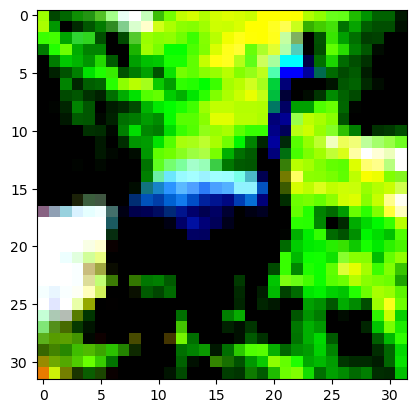

In [25]:
from matplotlib import pyplot as plt

plt.imshow(img.permute(1,2,0))

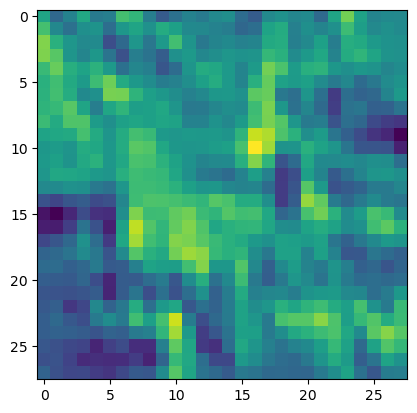

In [26]:

out = conv1(img.unsqueeze(0))
plt.imshow(out[0,4].detach())

In [27]:
import torch.nn as nn

conv = nn.Conv2d(3, 16, kernel_size=3, padding=1)
print(conv.weight.shape)
print(conv.bias.shape) 

conv1 = nn.Conv2d(3, 16, kernel_size=5, padding=2)
print(conv1.weight.shape)
print(conv1.bias.shape)


torch.Size([16, 3, 3, 3])
torch.Size([16])
torch.Size([16, 3, 5, 5])
torch.Size([16])


torch.Size([1, 16, 32, 32])


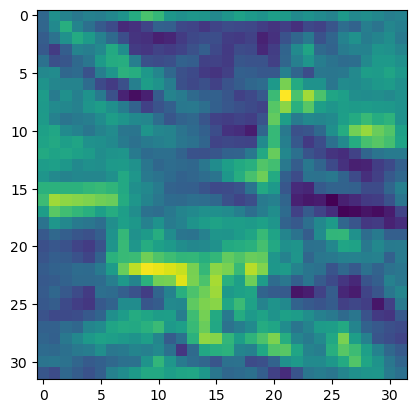

In [28]:
out = conv(img.unsqueeze(0))
print(out.shape)
plt.imshow(out[0,0].detach())

torch.Size([1, 16, 32, 32])


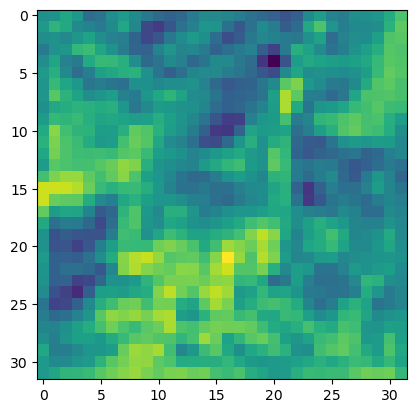

In [29]:
out = conv1(img.unsqueeze(0))
print(out.shape)
plt.imshow(out[0,0].detach())

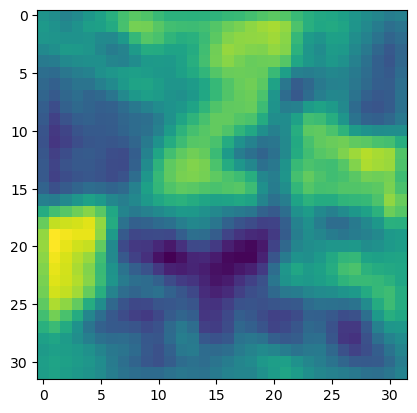

In [30]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight.fill_(1.0/9.0) # average in each channel and then add together within a neighborhood of 3x3

out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

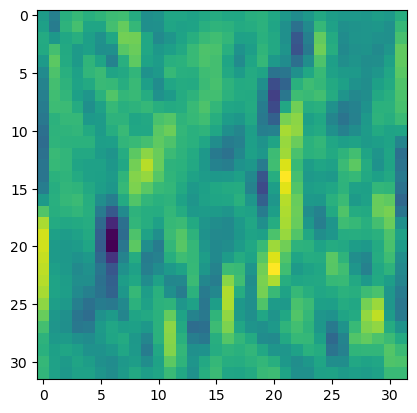

In [31]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0],
                                   [-1.0, 0, 1.0]]) # identify vertical edges

out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

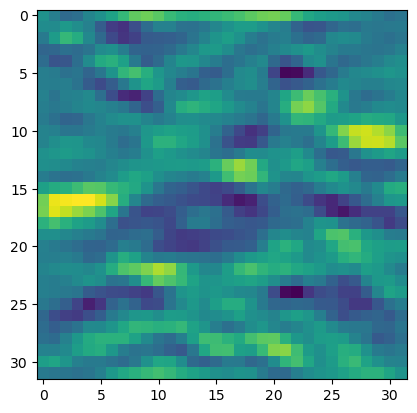

In [32]:
with torch.no_grad():
    conv.bias.zero_()
    conv.weight[:] = torch.tensor([[-1.0, -1.0, -1.0],
                                   [   0,    0,    0],
                                   [ 1.0,  1.0,  1.0]]) # horizontal vertical edges

out = conv(img.unsqueeze(0))
plt.imshow(out[0,0].detach())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 16, 16])


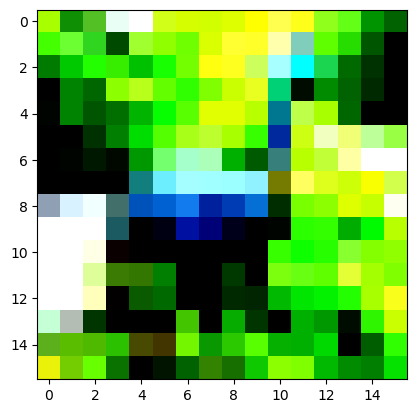

In [33]:
pool = nn.MaxPool2d(2)
out = pool(img)
print(out.shape)
plt.imshow(out.permute(1,2,0))

In [34]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1), # output: 1 * 16 * 32 * 32
                                            # kernel: 3 * 3 * 3 (n_in_features * kernel_width * kernel_height)
                                            # batch of kernels: 16 * 3 * 3 * 3 (weight tensor) (n_kernels * n_in_features * kernel_width * kernel_height)
                                            # biases: 1 bias per kernel, in total 16
    nn.Tanh(),
    nn.MaxPool2d(2),    # input: 1 * 16 * 32 * 32, output: 1 * 16 * 16 * 16

    nn.Conv2d(16, 8, kernel_size=3, padding=1), # output: 1 * 8 * 16 * 16
                                            # kernel: 16 * 3 * 3 (n_in_features * kernel_width * kernel_height)
                                            # batch of kernels: 8 * 16 * 3 * 3 (weight) (n_kernels * n_in_features * kernel_width * kernel_height)
                                            # biases: 1 bias per kernel, in total 8
    nn.Tanh(),
    nn.MaxPool2d(2),    # input: 1 * 8 * 16 * 16, output: 1 * 8 * 8 * 8

    nn.Flatten(),      # we need to cerate a 1D version of what max pool returns and pass it to linear layer
    nn.Linear(512, 32), # output: 1 * 32
                        # 32 neurons, each having 512 weights and 1 bias
                        # weights: 32 * 512, biases: 32
    nn.Tanh(),
    nn.Linear(32, 2),   # output: 1 * 2
                        # 2 neurons, each having 32 weights and 1 bias
                        # weights: 2 * 32, biases: 2
    nn.Softmax(dim=1)
)

In [35]:
model(img.unsqueeze(0))

tensor([[0.4732, 0.5268]], grad_fn=<SoftmaxBackward0>)

In [36]:
[param.shape for param in model.parameters()]

[torch.Size([16, 3, 3, 3]),
 torch.Size([16]),
 torch.Size([8, 16, 3, 3]),
 torch.Size([8]),
 torch.Size([32, 512]),
 torch.Size([32]),
 torch.Size([2, 32]),
 torch.Size([2])]

In [37]:
[param.numel() for param in model.parameters()]


[432, 16, 1152, 8, 16384, 32, 64, 2]

In [38]:
sum([param.numel() for param in model.parameters()])

18090

In [39]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(512, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        self.sftmx = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 512) # flatten
        out = self.sftmx(self.fc2(self.act3(self.fc1(out))))
        return out

In [40]:
model = Net()

[param.numel() for param in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [41]:
model(img.unsqueeze(0))

tensor([[0.5227, 0.4773]], grad_fn=<SoftmaxBackward0>)

In [42]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(512, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 512) # flatten
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [43]:
model = Net()

[param.numel() for param in model.parameters()]

[432, 16, 1152, 8, 16384, 32, 64, 2]

In [44]:
model(img.unsqueeze(0))

tensor([[-0.0075,  0.2142]], grad_fn=<AddmmBackward0>)

In [45]:
def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for (img, lbls) in train_loader:
            outs = model(img)
            loss = loss_fn(outs, lbls)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print("epoch %d, loss %f" %(epoch, train_loss/len(train_loader))) # average loss over all batches

In [46]:
import torch.optim as optim
import torch.utils
import torch.utils.data

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset_val, batch_size=64, shuffle=False)

In [47]:
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
)

epoch 1, loss 0.561544
epoch 2, loss 0.483348
epoch 3, loss 0.450158
epoch 10, loss 0.326817
epoch 20, loss 0.290015
epoch 30, loss 0.265445
epoch 40, loss 0.247486
epoch 50, loss 0.231824
epoch 60, loss 0.218858
epoch 70, loss 0.207570
epoch 80, loss 0.191058
epoch 90, loss 0.179691
epoch 100, loss 0.166409


In [68]:
def validate(model, loader):
    total = 0
    correct = 0
    for (imgs, lbls) in loader:
        imgs = imgs.to(device=dev)
        lbls = lbls.to(device=dev) 
        outs = model(imgs)
        max_vals, max_indexes = outs.max(dim=1)
        correct += ((max_indexes == lbls).sum())
        total += imgs.shape[0]
    print("accuracy %f" %(correct/total))

In [49]:
validate(model, val_loader)

accuracy 0.845500


In [50]:
torch.save(model.state_dict(), "./model.t")

In [51]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load("./model.t"))

<All keys matched successfully>

In [52]:
validate(loaded_model, val_loader)

accuracy 0.845500


In [88]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [89]:
def training_loop(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            imgs = imgs.to(device=dev)
            lbls = lbls.to(device=dev) 
            outs = model(imgs)
            loss = loss_fn(outs, lbls)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print("epoch %d, loss %f" %(epoch, train_loss/len(train_loader))) # average loss over all batches

model = Net().to(device=dev)

In [55]:
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
)

epoch 1, loss 0.579292
epoch 2, loss 0.499423
epoch 3, loss 0.474120
epoch 10, loss 0.338109
epoch 20, loss 0.295610
epoch 30, loss 0.270116
epoch 40, loss 0.246834
epoch 50, loss 0.230307
epoch 60, loss 0.213896
epoch 70, loss 0.198702
epoch 80, loss 0.186012
epoch 90, loss 0.171723
epoch 100, loss 0.157938


In [56]:
# import torch.nn as nn
# import torch.nn.functional as F

# class NetWidth(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)     # output: 32*32*32 (!maxpooling 32*16*16)
#         self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)    # output: 16*16*16 (!maxpooling 16*8*8)

#         self.fc1 = nn.Linear(16*8*8, 32)
#         self.fc2 = nn.Linear(32, 2)

#     def forward(self, x):
#         out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)    # !maxpooling 32*16*16
#         out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)  # !maxpooling 16*8*8
#         out = out.view(-1, 16*8*8) # flatten
#         out = self.fc2(torch.tanh(self.fc1(out)))
#         return out

import torch.nn as nn
import torch.nn.functional as F

class NetWidth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1)     # output: 32*32*32 (!maxpooling 32*16*16)
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)    # output: (n_chann/2)*16*16 (!maxpooling (n_chann/2)*8*8)

        self.fc1 = nn.Linear((self.n_chann//2)*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)    # !maxpooling 32*16*16
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)  # !maxpooling 16*8*8
        out = out.view(-1, (self.n_chann//2)*8*8) # flatten
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [57]:
model = NetWidth(32)

In [58]:
[param.shape for param in model.parameters()]

[torch.Size([32, 3, 3, 3]),
 torch.Size([32]),
 torch.Size([16, 32, 3, 3]),
 torch.Size([16]),
 torch.Size([32, 1024]),
 torch.Size([32]),
 torch.Size([2, 32]),
 torch.Size([2])]

In [59]:
[param.numel() for param in model.parameters()]

[864, 32, 4608, 16, 32768, 32, 64, 2]

In [60]:
sum([param.numel() for param in model.parameters()])

38386

In [61]:
def training_loop_L2(n_epochs, model, loss_fn, optimizer, train_loader):
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for (imgs, lbls) in train_loader:
            imgs = imgs.to(device=dev)
            lbls = lbls.to(device=dev) 
            outs = model(imgs)
            loss = loss_fn(outs, lbls)

            L2_lam = 0.0001 # weight decay
            loss += L2_lam * sum(p.pow(2.0).sum() for p in model.parameters()) # penalty on loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss
        if epoch % 10 == 0 or epoch <= 3:
            print("epoch %d, loss %f" %(epoch, train_loss/len(train_loader))) # average loss over all batches

In [62]:
import torch

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = NetWidth().to(device=dev)

In [63]:
training_loop_L2(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
)

epoch 1, loss 0.559396
epoch 2, loss 0.472671
epoch 3, loss 0.439037
epoch 10, loss 0.330692
epoch 20, loss 0.279321
epoch 30, loss 0.245262
epoch 40, loss 0.215381
epoch 50, loss 0.190123
epoch 60, loss 0.171202
epoch 70, loss 0.151824
epoch 80, loss 0.128606
epoch 90, loss 0.112500
epoch 100, loss 0.096860


In [69]:
validate(model, train_loader)

accuracy 0.965200


In [71]:
model = NetWidth().to(device=dev)
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01, weight_decay=0.0002),
    train_loader=train_loader
)

epoch 1, loss 0.537457
epoch 2, loss 0.455920
epoch 3, loss 0.410364
epoch 10, loss 0.312154
epoch 20, loss 0.268619
epoch 30, loss 0.234517
epoch 40, loss 0.206579
epoch 50, loss 0.184042
epoch 60, loss 0.159564
epoch 70, loss 0.137350
epoch 80, loss 0.120199
epoch 90, loss 0.100963
epoch 100, loss 0.084316


In [75]:
validate(model, train_loader)

accuracy 0.963300


In [76]:
class NetDropOut(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1)     # output: 32*32*32 (!maxpooling 32*16*16)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)    # output: (n_chann/2)*16*16 (!maxpooling (n_chann/2)*8*8)
        self.conv2_dropout = nn.Dropout2d(p=0.4)

        self.fc1 = nn.Linear((self.n_chann//2)*8*8, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)    # !maxpooling 32*16*16
        out = self.conv1_dropout(out)

        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)  # !maxpooling 16*8*8
        out = self.conv2_dropout(out)

        out = out.view(-1, (self.n_chann//2)*8*8) # flatten
        out = self.fc2(torch.tanh(self.fc1(out)))
        return out

In [77]:
model = NetDropOut().to(device=dev)
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
    )

epoch 1, loss 0.575227
epoch 2, loss 0.501066
epoch 3, loss 0.472117
epoch 10, loss 0.379566
epoch 20, loss 0.351040
epoch 30, loss 0.327252
epoch 40, loss 0.308645
epoch 50, loss 0.295995
epoch 60, loss 0.282843
epoch 70, loss 0.269632
epoch 80, loss 0.257583
epoch 90, loss 0.243155
epoch 100, loss 0.236907


In [79]:
print(validate(model, train_loader), validate(model, val_loader))

accuracy 0.906000
accuracy 0.878000
None None


In [95]:
class NetDepth(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1)     # output: 32*32*32 (!maxpooling self.n_chann*16*16)
        
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)    # output: (n_chann/2)*16*16 (!maxpooling (n_chann/2)*8*8)

        self.conv3 = nn.Conv2d((self.n_chann//2), (self.n_chann//2), kernel_size=3, padding=1)# output: (n_chann/2)*8*8 (!maxpooling (n_chann/2)*4*4)

        self.fc1 = nn.Linear((self.n_chann//2)*4*4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)    # !maxpooling self.n_chann*16*16

        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)  # !maxpooling (n_chann/2)*8*8

        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)  # !maxpooling (n_chann/2)*4*4

        out = out.view(-1, (self.n_chann//2)*4*4) # flatten
        out = self.fc2(torch.relu(self.fc1(out)))
        return out

In [96]:
model = NetDepth().to(device=dev)
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
    )

epoch 1, loss 0.688350
epoch 2, loss 0.660351
epoch 3, loss 0.573459
epoch 10, loss 0.346138
epoch 20, loss 0.297159
epoch 30, loss 0.264222
epoch 40, loss 0.235195
epoch 50, loss 0.212247
epoch 60, loss 0.185651
epoch 70, loss 0.162202
epoch 80, loss 0.139912
epoch 90, loss 0.117647
epoch 100, loss 0.092580


In [97]:
print(validate(model, train_loader), validate(model, val_loader))

accuracy 0.969100
accuracy 0.909000
None None


In [99]:
class NetRes(nn.Module):
    def __init__(self, n_chann = 32):
        super().__init__()
        self.n_chann = n_chann
        self.conv1 = nn.Conv2d(3, self.n_chann, kernel_size=3, padding=1)     # output: 32*32*32 (!maxpooling self.n_chann*16*16)
        
        self.conv2 = nn.Conv2d(self.n_chann, (self.n_chann//2), kernel_size=3, padding=1)    # output: (n_chann/2)*16*16 (!maxpooling (n_chann/2)*8*8)

        self.conv3 = nn.Conv2d((self.n_chann//2), (self.n_chann//2), kernel_size=3, padding=1)# output: (n_chann/2)*8*8 (!maxpooling (n_chann/2)*4*4)

        self.fc1 = nn.Linear((self.n_chann//2)*4*4, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)    # !maxpooling self.n_chann*16*16

        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)  # !maxpooling (n_chann/2)*8*8
        
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # skip node  # !maxpooling (n_chann/2)*4*4

        out = out.view(-1, (self.n_chann//2)*4*4) # flatten
        out = self.fc2(torch.relu(self.fc1(out)))
        return out

In [100]:
model = NetRes().to(device=dev)
training_loop(
    n_epochs=100,
    model=model,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optim.SGD(model.parameters(), lr=0.01),
    train_loader=train_loader
    )

epoch 1, loss 0.660719
epoch 2, loss 0.550960
epoch 3, loss 0.461649
epoch 10, loss 0.329723
epoch 20, loss 0.284220
epoch 30, loss 0.255228
epoch 40, loss 0.228262
epoch 50, loss 0.194920
epoch 60, loss 0.169991
epoch 70, loss 0.147930
epoch 80, loss 0.129743
epoch 90, loss 0.104053
epoch 100, loss 0.081476


In [101]:
print(validate(model, train_loader), validate(model, val_loader))

accuracy 0.974600
accuracy 0.895000
None None
